# 04_Component3_Persona_Clustering.ipynb



## 1. Environment Setup & Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")

## 2. Load Data & Precomputed Metrics


In [3]:
# ABSA sentiment averages per provider
# Expect a DataFrame with columns: provider_id, aspect, avg_sentiment
sent_df = pd.read_excel("absa_aspect_sentiment.xlsx") \
             .groupby(['record_id','aspect_category'])['polarity'] \
             .mean() \
             .unstack(fill_value=0)

# Gap metrics per provider
# Columns: provider_id, aspect, hybrid_gap
gap_df = pd.read_excel("gap_analysis_metrics.xlsx") \
            .groupby(['id','aspect'])['hybrid_gap'] \
            .mean() \
            .unstack(fill_value=0)

# Optional: overall satisfaction per provider
sat_df = pd.read_excel("gap_analysis_metrics.xlsx") \
            .groupby('id')['overall_satisfaction'] \
            .mean()

## 3. Combine into Provider‐Feature Matrix


In [4]:
# rename gap columns to indicate lower-is-better
gap_df = gap_df.add_prefix('gap_')
sent_df = sent_df.add_prefix('sent_')

# merge
providers = sent_df.join(gap_df, how='outer').fillna(0)
providers['overall_satisfaction'] = sat_df
providers.head()

,sent_career_guidance,sent_environment,sent_learning_opportunities,sent_mentorship,sent_professional_networking,sent_team_collaboration,sent_technical_support,sent_workload,gap_career_guidance,gap_environment,gap_learning_opportunities,gap_mentorship,gap_professional_networking,gap_team_collaboration,gap_technical_support,gap_workload,overall_satisfaction
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.6,0.6,1.0,0.6,0.6,0.6,0.6,1.0,NaN
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
10,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## 4. Student Preference Input


In [9]:
# Predefined importance weights for each aspect (sum to 1)
# Adjust these values based on stakeholder input or domain priorities

weights = {
    'mentorship':             0.20,  # strong emphasis on quality of mentorship
    'workload':               0.10,  # moderate concern for workload balance
    'learning_opportunities': 0.25,  # highest priority on hands‑on learning
    'environment':            0.10,  # comfort and tools matter moderately
    'team_collaboration':     0.15,  # importance of good teamwork and communication
    'professional_networking':0.10,  # value of building a professional network
    'career_guidance':        0.10   # need for feedback on career progression
}

# Normalize just to be safe
total = sum(weights.values())
weights = {asp: w/total for asp, w in weights.items()}

print("Using predefined, normalized weights:")
for asp, w in weights.items():
    print(f"  {asp:25s}: {w:.2f}")


Using predefined, normalized weights:
  mentorship               : 0.20
  workload                 : 0.10
  learning_opportunities   : 0.25
  environment              : 0.10
  team_collaboration       : 0.15
  professional_networking  : 0.10
  career_guidance          : 0.10


## 5. Scoring Model (Weighted Aggregation)


In [17]:
# 0. Ensure your weights dict is defined first:
weights = {
    'mentorship':             0.20,
    'workload':               0.10,
    'learning_opportunities': 0.25,
    'environment':            0.10,
    'team_collaboration':     0.15,
    'professional_networking':0.10,
    'career_guidance':        0.10
}

# 1. Derive aspects to use from weights
aspects = list(weights.keys())

# 2. Work on a copy of providers/features
feat = providers.copy()

# 3. Identify existing sentiment/gap columns for these aspects
sent_cols = [f"sent_{asp}" for asp in aspects if f"sent_{asp}" in feat.columns]
gap_cols  = [f"gap_{asp}"  for asp in aspects if f"gap_{asp}"  in feat.columns]

print("Using aspects:", aspects)
print("Found sentiment columns:", sent_cols)
print("Found gap columns     :", gap_cols)

# 4. Normalize sentiment features to [0,1]
from sklearn.preprocessing import MinMaxScaler
if sent_cols:
    scaler_sent = MinMaxScaler()
    feat[sent_cols] = scaler_sent.fit_transform(feat[sent_cols])

# 5. Normalize gap features to [0,1] and invert
if gap_cols:
    scaler_gap = MinMaxScaler()
    feat[gap_cols] = scaler_gap.fit_transform(feat[gap_cols])
    feat[gap_cols] = 1.0 - feat[gap_cols]

# 6. Build combined feature list and matching weight list
combined_cols = sent_cols + gap_cols
weights_list  = [weights[col.split("sent_")[1]] for col in sent_cols] \
              + [weights[col.split("gap_")[1]]  for col in gap_cols]

print("Combined cols:", combined_cols)
print("Weights list :", weights_list)

# 7. Compute recommendation scores
import numpy as np
X = feat[combined_cols].values
w = np.array(weights_list)
feat['recommendation_score'] = X.dot(w)

# 8. Show top 10
top_recs = feat[['recommendation_score']].nlargest(10, 'recommendation_score')
print("Top 10 recommendations:")
print(top_recs)



Using aspects: ['mentorship', 'workload', 'learning_opportunities', 'environment', 'team_collaboration', 'professional_networking', 'career_guidance']
Found sentiment columns: ['sent_mentorship', 'sent_workload', 'sent_learning_opportunities', 'sent_environment', 'sent_team_collaboration', 'sent_professional_networking', 'sent_career_guidance']
Found gap columns     : ['gap_mentorship', 'gap_workload', 'gap_learning_opportunities', 'gap_environment', 'gap_team_collaboration', 'gap_professional_networking', 'gap_career_guidance']
Combined cols: ['sent_mentorship', 'sent_workload', 'sent_learning_opportunities', 'sent_environment', 'sent_team_collaboration', 'sent_professional_networking', 'sent_career_guidance', 'gap_mentorship', 'gap_workload', 'gap_learning_opportunities', 'gap_environment', 'gap_team_collaboration', 'gap_professional_networking', 'gap_career_guidance']
Weights list : [0.2, 0.1, 0.25, 0.1, 0.15, 0.1, 0.1, 0.2, 0.1, 0.25, 0.1, 0.15, 0.1, 0.1]
Top 10 recommendations:
  

## 6. Explanations & Top Reasons


In [7]:
def explain(record_id, top_n=3):
    """
    For a given record (or provider) ID, compute the top_n aspects contributing
    to its recommendation_score and return formatted explanation lines.
    """
    row = feat.loc[record_id]
    contribs = {}

    # consider only aspects that have both sentiment and gap columns present
    for asp in aspects:
        sent_col = f"sent_{asp}"
        gap_col  = f"gap_{asp}"
        if sent_col in row.index and gap_col in row.index:
            contrib = weights[asp] * (row[sent_col] + row[gap_col])
            contribs[asp] = contrib

    # sort by contribution descending and take top_n
    top_aspects = sorted(contribs.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # format explanation lines
    lines = [f"{asp}: weight={weights[asp]:.2f}, " \
             f"sentiment={row[f'sent_{asp}']:.2f}, gap={row[f'gap_{asp}']:.2f}, " \
             f"contrib={score:.2f}"
             for asp, score in top_aspects]
    return "\n".join(lines)

# Example usage for top-3 recommended records
top3 = feat['recommendation_score'].nlargest(3).index
for rid in top3:
    print(f"Record {rid} → recommendation_score = {feat.at[rid,'recommendation_score']:.2f}")
    print("Top contributing aspects:")
    print(explain(rid, top_n=3))
    print("-" * 40)


Record 626 → recommendation_score = 1.80
Top contributing aspects:
learning_opportunities: weight=0.25, sentiment=1.00, gap=1.00, contrib=0.50
mentorship: weight=0.20, sentiment=1.00, gap=1.00, contrib=0.40
team_collaboration: weight=0.15, sentiment=1.00, gap=1.00, contrib=0.30
----------------------------------------
Record 467 → recommendation_score = 1.65
Top contributing aspects:
learning_opportunities: weight=0.25, sentiment=1.00, gap=1.00, contrib=0.50
mentorship: weight=0.20, sentiment=0.00, gap=1.00, contrib=0.20
workload: weight=0.10, sentiment=1.00, gap=1.00, contrib=0.20
----------------------------------------
Record 381 → recommendation_score = 1.57
Top contributing aspects:
mentorship: weight=0.20, sentiment=1.00, gap=1.00, contrib=0.40
learning_opportunities: weight=0.25, sentiment=0.50, gap=1.00, contrib=0.38
team_collaboration: weight=0.15, sentiment=1.00, gap=1.00, contrib=0.30
----------------------------------------


## 7. Visualization of Ranked Providers


C:\Users\piyum\AppData\Local\Temp\ipykernel_33620\2034313021.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


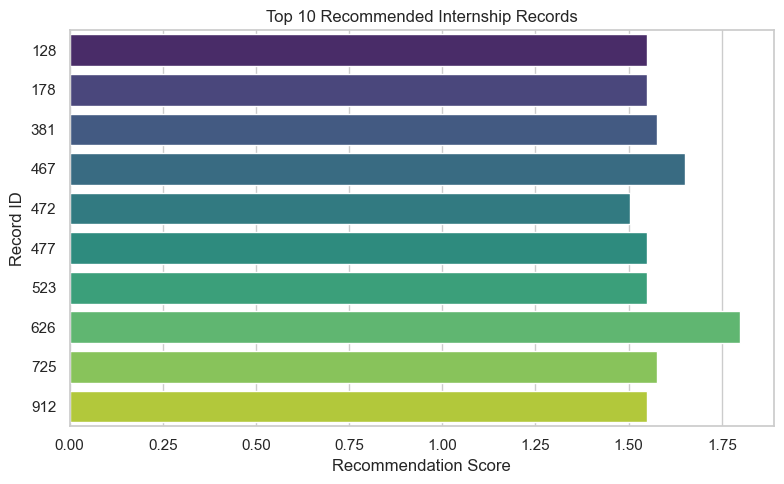

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ensure we have an explicit 'record_id' column
feat_plot = feat.reset_index().rename(columns={'index': 'record_id'})

# 2. Grab the top 10 by recommendation_score
top10 = feat_plot.nlargest(10, 'recommendation_score')[['record_id', 'recommendation_score']]

# 3. Plot horizontal bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10,
    x='recommendation_score',
    y='record_id',
    palette='viridis',
    orient='h'
)
plt.title("Top 10 Recommended Internship Records")
plt.xlabel("Recommendation Score")
plt.ylabel("Record ID")
plt.tight_layout()
plt.show()


# 7. Generate Textual Recommendations & Comments per Record ID

In [9]:
# 7. Generate Recommendations & Comments for All Records and Display as Table

import pandas as pd

# 7.1 Ensure 'record_id' column exists
if 'record_id' not in feat.columns:
    feat = feat.reset_index().rename(columns={'index': 'record_id'})

# 7.2 Compute recommendations & comments
records = []
for _, row in feat.iterrows():
    rid = row['record_id']
    # Compute per‑aspect contributions
    contribs = {}
    for asp in weights:
        sent_col = f"sent_{asp}"
        gap_col = f"gap_{asp}"
        if sent_col in row and gap_col in row:
            contribs[asp] = weights[asp] * (row[sent_col] + row[gap_col])
    # Get top 3 aspects
    top_asps = sorted(contribs.items(), key=lambda x: x[1], reverse=True)[:3]
    asp_list = [asp.replace('_', ' ').title() for asp, _ in top_asps]
    comment = (
        f"Recommended for strong {asp_list[0]}, {asp_list[1]}, "
        f"and {asp_list[2]}."
    )
    records.append({
        'record_id': rid,
        'recommendation_score': row['recommendation_score'],
        'top_aspects': ", ".join(asp_list),
        'comment': comment
    })

rec_df = pd.DataFrame(records).sort_values(
    by='recommendation_score', ascending=False
)

# 7.3 Save to Excel
rec_df.to_excel("recommendations_and_comments.xlsx", index=False)

# 7.4 Display full table
from IPython.display import display

display(rec_df)


,record_id,recommendation_score,top_aspects,comment
321,626.0,1.800,"Learning Opportunities, Mentorship, Team Colla...","Recommended for strong Learning Opportunities,..."
224,467.0,1.650,"Learning Opportunities, Mentorship, Workload","Recommended for strong Learning Opportunities,..."
188,381.0,1.575,"Mentorship, Learning Opportunities, Team Colla...","Recommended for strong Mentorship, Learning Op..."
377,725.0,1.575,"Mentorship, Learning Opportunities, Team Colla...","Recommended for strong Mentorship, Learning Op..."
48,128.0,1.550,"Learning Opportunities, Mentorship, Career Gui...","Recommended for strong Learning Opportunities,..."
...,...,...,...,...
167,348.0,0.125,"Learning Opportunities, Mentorship, Workload","Recommended for strong Learning Opportunities,..."
176,360.0,0.125,"Learning Opportunities, Mentorship, Workload","Recommended for strong Learning Opportunities,..."
150,312.0,0.125,"Learning Opportunities, Mentorship, Workload","Recommended for strong Learning Opportunities,..."
481,967.0,0.125,"Learning Opportunities, Mentorship, Workload","Recommended for strong Learning Opportunities,..."


## 8. Save Recommendation Engine


In [10]:
feat.to_excel("provider_scores_and_features.xlsx")